# Apziva Project 1 - Happy Customers

#### Background:

We are one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. From operational standpoint we have been facing several different challenges and everyday we are trying to address these challenges.

We thrive on making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

Getting feedback from customers is not easy either, but we do our best to get constant feedback from our customers. This is a crucial function to improve our operations across all levels.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.

#### Data Description:

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers <br/>
X1 = my order was delivered on time  <br/>
X2 = contents of my order was as I expected  <br/>
X3 = I ordered everything I wanted to order <br/>
X4 = I paid a good price for my order <br/>
X5 = I am satisfied with my courier <br/>
X6 = the app makes ordering easy for me <br/>

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

### Data Wrangling and EDA

In [68]:
# First, let's import the necessary libraries:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, tree
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import warnings
%matplotlib inline

In [5]:
# Now we need to upload the data and understand its properties:
C_data=pd.read_csv('ACME_Data.csv')
C_data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [6]:
#Now let's check the data for missing values and data types
C_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


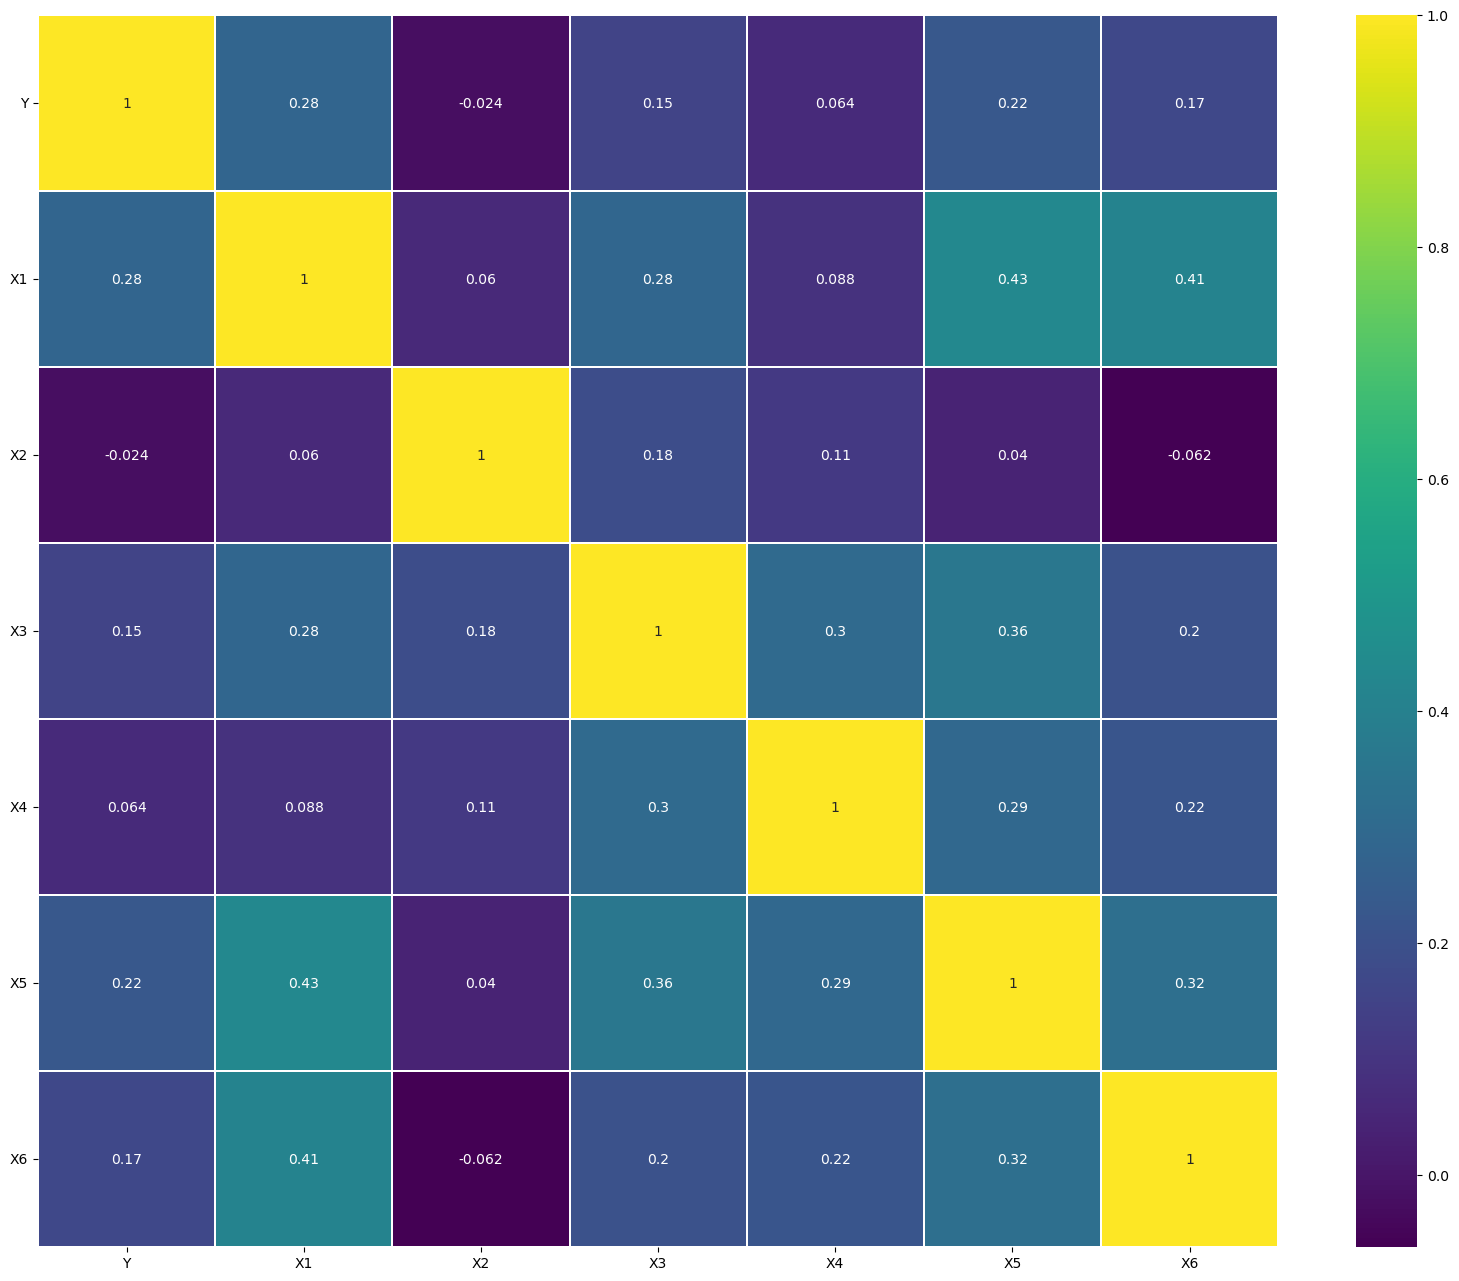

In [7]:
#As we can see we don't have any missing values and all of our columns are integers 
#Since our columns are integers, we can check their correlation with the target column 'Y' and with each other using a heatplot.
plt.figure(figsize=(20,16))
sns.heatmap(C_data.corr(), linewidth=.1, annot=True, cmap='viridis')
plt.yticks(rotation=0)
plt.show()

The heatmap shows that no particular column has a strong correlation with the target column 'Y'. But if we choose one column showing the highest correlation out of all, it would be X1 ('my order was delivered on time'), which makes sense, since for most customers, ordering online, on-time delivery is a priority. <br/>
The feature X2 ('contents of my order was as I expected'), on the other hand, shows slightly negative correlation with the target column, which seems odd but can be explained by the small size of the data. <br/>
It's worth mentioning that X1 ('my order was delivered on time') also has a moderate correlation with X5 ('I am satisfied with my courier') and X6 ('the app makes ordering easy for me'). The correlation between X1 and X5 seems logical, since both rankings belong to the delivery category and the customer who is satisfied with the delivery time is prone to also be satisfied with the courier's service. But the correlation between X1 and X6 doesn't seem to be cause and effect relationship. They just might be two different things that customers appreciate more than other categories. And again, the limited data also affects the correlation coefficents.

### Modeling

Since the data doesn't have any missing values and doesn't require any preprocessing, let's go ahead and start the modeling. Let's start with the Logistic Regression.

In [11]:
#Since we only have the training data, we'll divide it only into X and y (not training and testing)
y=C_data[['Y']]
X=C_data.drop('Y', axis=1)

In [12]:
#Before modeling let's take a look at our target value distribution.
y.value_counts()

Y
1    69
0    57
Name: count, dtype: int64

In [81]:
# It looks like the target column is pretty equally distributed.
#Now let's create our Logistic Regression model
lr=LogisticRegression()
lr.fit(X, y.values.ravel())
Score=lr.score(X, y)
print("The accuracy of the Logistic Regression model on the training data is : {}".format(Score))

The accuracy of the Logistic Regression model on the training data is : 0.5793650793650794


Our model showed only 58% accuracy on our data, let's try to have a look at our model feature importances and eliminate any features that don't have significant impact on our results:

In [15]:
Feature_importance=pd.DataFrame({
    'Feature' : X.columns,
    'Coefficient' : lr.coef_[0]
})
print(Feature_importance)

  Feature  Coefficient
0      X1     0.535349
1      X2    -0.089048
2      X3     0.129735
3      X4    -0.006855
4      X5     0.206433
5      X6     0.092190


As we can see features X2, X4 and X6 don't contribute noticeable to our model performance, therefore let's try to create a new Log Regression model using only X1, X3 and X5.

In [83]:
X_n=X.drop(['X2','X4','X6'], axis=1)
lr2=LogisticRegression()
lr2.fit(X_n, y.values.ravel())
Score=lr2.score(X_n, y)
print("The accuracy of the Logistic Regression model with fewer features on the training data is : {}".format(Score))

The accuracy of the Logistic Regression model with fewer features on the training data is : 0.5873015873015873


Eliminating those features improved our model performance by only 1%. Now, let's try to do some hyperparameters tuning for our model in order to find the optimal parameters using GridSearch with Cross Validation.

In [19]:
lr1=LogisticRegression()
param_grid={
    'penalty' : ['l1', 'l2'],
    'C' : [0.01, 0.1, 1, 10, 100],
    'solver' : ['liblinear', 'saga'],
    'max_iter' : [100, 200, 500]
}

grid_search=GridSearchCV(lr1, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_n,y.values.ravel())

print('Best parameters:', grid_search.best_params_)
print('Best CV accuracy:', grid_search.best_score_)

Best parameters: {'C': 1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'saga'}
Best CV accuracy: 0.596


C:\Users\sirak\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The accuracy improved slightly again, but we are far below our target 73% mark. Let's switch to Decision Trees and try to improve the accuracy of our data. But we need to remember that Decision Trees are prone to overfitting on small datasets, and to prevent this, we'll set our max_depth parameter to 3.

The accuracy of the Decision Trees model on the training data is : 0.6984126984126984:


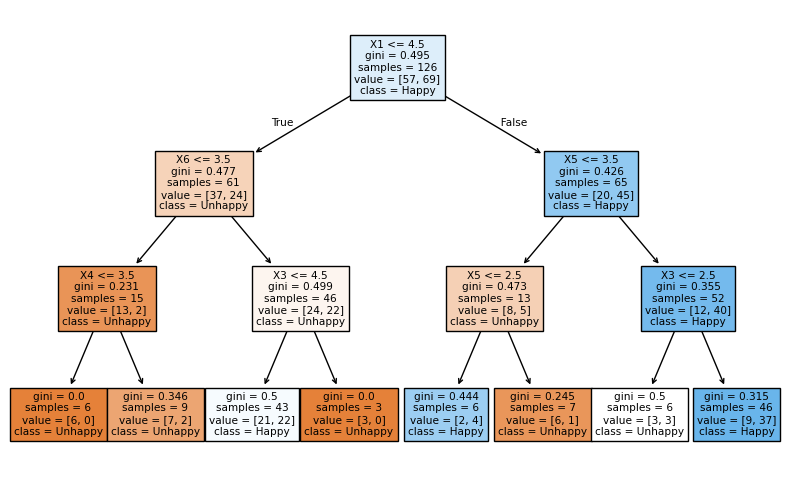

In [85]:
dt=DecisionTreeClassifier(max_depth=3, random_state=32)
dt.fit(X,y)
plt.figure(figsize=(10,6))

y_pred = dt.predict(X)
accuracy = accuracy_score(y, y_pred)
print('The accuracy of the Decision Trees model on the training data is : {}:'.format(accuracy))


tree.plot_tree(dt, feature_names=X.columns, class_names=['Unhappy', 'Happy'], filled=True)
plt.show()

Decision Trees showed much higher accuracy compared to Log Regression, but it's still not enough to hit our goal of 73%. Let's try to use GridSearch again to find the optimal hyperparameters for our model.

In [23]:
param_grid = {
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

grid_search=GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X,y.values.ravel())

print('Best parameters:', grid_search.best_params_)
print('Best CV accuracy:', grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV accuracy: 0.6510769230769231


Hyperparameter tuning actually decreased our model accuracy, probably because of the limited data and cross validation. Let's have a look at our feature importances for this model and try a new model with fewer features.

In [25]:
#Let's take a look at our feature importances
Feature_importance_dt=pd.DataFrame({
    'Feature' : X.columns,
    'Coefficient' : dt.feature_importances_
})
print(Feature_importance_dt)

  Feature  Coefficient
0      X1     0.352007
1      X2     0.000000
2      X3     0.153503
3      X4     0.022264
4      X5     0.303685
5      X6     0.168540


In [26]:
#Let's eliminate features X2 and X4 this time
X_dt=X.drop(['X2','X4'], axis=1)

The accuracy of the Decision Trees model with fewer features on the training data is : 0.6984126984126984:


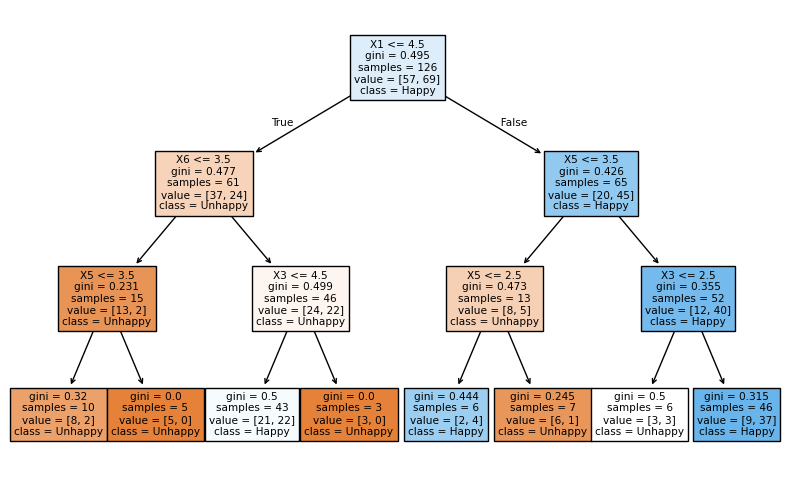

In [87]:
dt1=DecisionTreeClassifier(max_depth=3, random_state=32)
dt1.fit(X_dt,y)
plt.figure(figsize=(10,6))

y_pred = dt1.predict(X_dt)
accuracy = accuracy_score(y, y_pred)
print('The accuracy of the Decision Trees model with fewer features on the training data is : {}:'.format(accuracy))


tree.plot_tree(dt1, feature_names=X_dt.columns, class_names=['Unhappy', 'Happy'], filled=True)
plt.show()

Fewer features also didn't improve the accuracy of the model. Now let's try our final model for the data, which is K nearest neighbors (KNN), for which scaling the data is the first step. But, since all our features have the same range of values (1 to 5), it shouldn't affect the results significantly. <br/>
Anyway, let's try both options:

In [94]:
warnings.filterwarnings("ignore", message="X has feature names, but KNeighborsClassifier was fitted without feature names")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_scaled, y.values.ravel())

y_pred = knn.predict(X)
accuracy = accuracy_score(y, y_pred)
print('The accuracy of the scaled KNN model on the training data is : {}:'.format(accuracy))

The accuracy of the scaled KNN model on the training data is : 0.5476190476190477:


The scaled KNN showed only 55% accuracy, let's now try the same model without scaling:

In [92]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X, y.values.ravel())

y_pred = knn.predict(X)
accuracy = accuracy_score(y, y_pred)
print('The accuracy of the unscaled KNN model on the training data is : {}:'.format(accuracy))

The accuracy of the unscaled KNN model on the training data is : 0.746031746031746:


Not scaling the data improved the results a lot and helped us to hit our target of 73% accuracy.Lastly,Let's take a look at our confusion matrix to understand if we have a lot of false positives or negatives.

KNN Training F1 score is 0.7777777777777778:


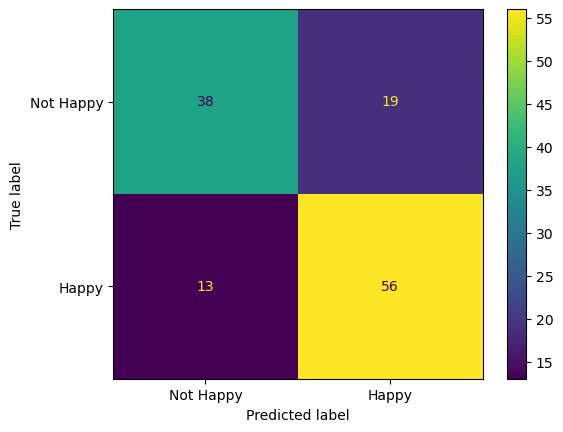

In [78]:
knn.fit(X,y.values.ravel())
y_pred=knn.predict(X)

f1=f1_score(y, y_pred)
print('KNN Training F1 score is {}:'.format(f1))

display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Not Happy', 'Happy'])
display_cm.plot()
plt.show()

It performs pretty well on both positives and negatives. </br>
In Summary, the overall accuracy and the absense of a lot of false positives and false negatives makes the __KNN__ the best performing model for our data. <br/>


### Final model
__KNN (k=3)__ <br/>
Accuracy : ~__75%__ <br/>
F1 score : ~ __78%__ <br/>
<br/>
<br/>
Additionally, based on feature importances of the previous models and the correlation matrix, we would recommend choosing features X1, X3 and X5 as the minimal set of features for predicting customer satisfaction with the service. X6 can also be added to the list, but considering its moderate correlation with X5 and X1, it doesn't add much additional value. <br/>

### Final recommended  set of features <br/>
X1 = my order was delivered on time <br/>
X3 = I ordered everything I wanted to order <br/>
X5 = I am satisfied with my courier <br/>
X6 = the app makes ordering easy for me __(Optional)__ <br/>
